In [1]:
import numpy as np
from astropy.modeling import models, fitting
from astropy.table import Table
from matplotlib import rcParams
rcParams['font.size'] = 12
import matplotlib.pyplot as plt
from photutils.datasets import (make_random_gaussians_table,
                                make_noise_image,
                                make_gaussian_sources_image)
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch, SqrtStretch
from scipy import stats
norm1 = ImageNormalize(stretch=LogStretch())
norm2 = ImageNormalize(stretch=LogStretch())

np.random.seed(39)

tshape = (101, 101)
cen = ((tshape[0]-1)/2., (tshape[0]-1)/2.)
mu, sigma = 1e-2, 1e-2
noise =  (1e-3*make_noise_image(tshape, type='poisson', mean=1e-3) +
          make_noise_image(tshape, type='gaussian', mean=mu, stddev=sigma))
#          make_gaussian_sources_image(tshape, sources)

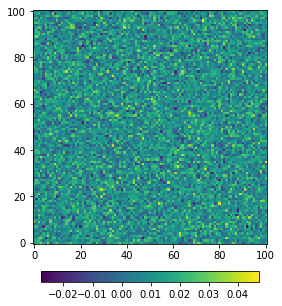

In [2]:
plt.figure(figsize=(5,5))
plt.imshow(noise, cmap='viridis', aspect=1, interpolation='nearest',origin='lower')
plt.colorbar(orientation='horizontal', fraction=0.04, pad=0.1) 

In [193]:
np.random.seed(42)
n_star = 1
# star_pos = tshape[0]*np.random.random(size=(n_star,2))
star_pos = [(cen[0]+2,cen[0]-1)]

In [194]:
yy, xx = np.mgrid[:tshape[0], :tshape[1]]
dist_maps = [np.sqrt((xx-x0)**2+(yy-y0)**2) for (x0,y0) in star_pos]
dist_map = np.sqrt((xx-cen[0])**2+(yy-cen[1])**2)

In [195]:
def power1d(x, n, theta, I_theta): 
    x[x<=0] = x[x>0].min()
    a = I_theta/(theta)**(-n)
    y = a * np.power(x, -n)
    return y

def power2d(x, y, n, theta, I_theta, cen=cen): 
    d = np.sqrt((x-cen[0])**2+(y-cen[1])**2)
    a = I_theta/(theta)**(-n)
    d[d<=0] = d[d>0].min()
    z = a * np.power(d, -n) 
    return z 

In [266]:
A, gamma, alpha = 500, 3, 3
n, theta = 2, 10
ro, phio = cart2pol(star_pos[0][0]-cen[0],star_pos[0][1]-cen[1])

moffat2d_s = [models.Moffat2D(amplitude=A, x_0=x0, y_0=y0, 
                              gamma=gamma, alpha=alpha) for (x0,y0) in star_pos]
mask_inner  = image > 0.8*A
mask_outer  = np.logical_and.reduce([d_maps>5*gamma for d_maps in dist_maps])
mask = mask_inner | mask_outer

Text(0,0.5,'$\\rm Intersity$')

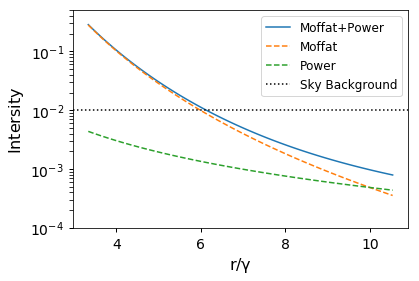

In [267]:
r = np.logspace(1,1.5,100)

moffat1d = models.Moffat1D(amplitude=A, x_0=0, gamma=gamma, alpha=alpha)
plt.semilogy(r/gamma, moffat1d(r) + power1d(r, n, theta=theta*gamma, I_theta=moffat1d(theta*gamma)),label="Moffat+Power")
plt.semilogy(r/gamma, moffat1d(r),ls="--",label="Moffat")
plt.semilogy(r/gamma, power1d(r, n, theta=theta*gamma, I_theta=moffat1d(theta*gamma)),ls="--",label="Power")
plt.axhline(mu,color="k",ls=":",label="Sky Background")
plt.legend(fontsize=12)
plt.ylim(1e-4,0.5)
plt.xlabel(r"$\rm r/\gamma$",fontsize=16)
plt.ylabel(r"$\rm Intersity$",fontsize=16)

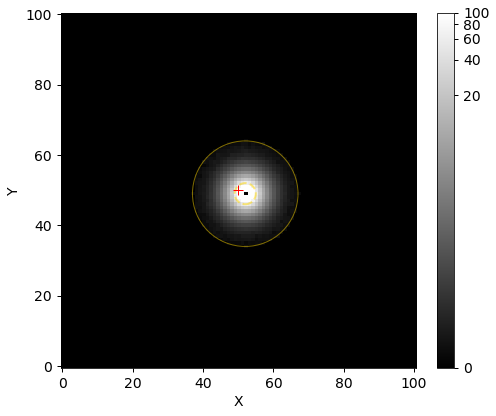

In [268]:
image = np.sum([m(xx,yy) for m in moffat2d_s] ,axis=0) + noise

plt.figure(figsize=(7,6))
image_ma = image.copy()
image_ma[mask] = 0
plt.imshow(image_ma, cmap='gray', aspect='equal', norm=norm1, vmin=0, vmax=100, interpolation='None',origin='lower')
plt.colorbar(fraction=0.045, pad=0.05) 

from photutils import CircularAperture, CircularAnnulus
aper1 = CircularAperture(star_pos, r=gamma)
aper2 = CircularAperture(star_pos, r=5*gamma)
aper1.plot(color='gold',ls="--",lw=2,alpha=0.5)
aper2.plot(color='gold',lw=1,label="",alpha=0.5)
plt.plot(50,50,"r+",ms=10)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()

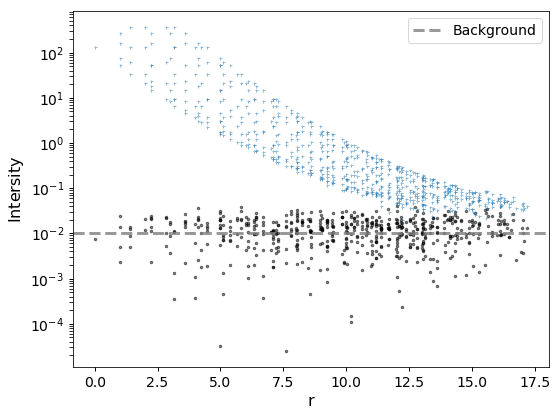

In [269]:
z = image[~mask].ravel()
d2 = dist_map[~mask].ravel()

x, y = (d2).copy(), z.copy()

plt.figure(figsize=(8,6))

plt.semilogy(x, y,"+",ms=3, alpha=0.5, zorder=2)
plt.semilogy(d2, noise[~mask].ravel(), "k.",ms=5, alpha=0.5, zorder=1)

r = np.logspace(np.log10(3*gamma-0.1),np.log10(100*1.4),100)
plt.axhline(mu,color="gray",ls="--",lw=3, alpha=0.8, zorder=2, label="Background")

plt.xlabel(r"$\rm r$",fontsize=16)
plt.ylabel(r"$\rm Intersity$",fontsize=16)
plt.legend(loc="best",fontsize=14)
plt.tight_layout()

## Nested Bayesian 

In [216]:
import dynesty
import time
from dynesty import plotting as dyplot

from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '4'})
rcParams.update({'xtick.major.width': '1.'})
rcParams.update({'xtick.minor.pad': '5.0'})
rcParams.update({'xtick.minor.size': '4'})
rcParams.update({'xtick.minor.width': '0.8'})
rcParams.update({'ytick.major.pad': '5.0'})
rcParams.update({'ytick.major.size': '4'})
rcParams.update({'ytick.major.width': '1.'})
rcParams.update({'ytick.minor.pad': '5.0'})
rcParams.update({'ytick.minor.size': '4'})
rcParams.update({'ytick.minor.width': '0.8'})
rcParams.update({'font.size': 14})

In [217]:
# gamma, alpha, n, a, mu, sigma
# truths = np.log10(A), gamma, alpha, x0, y0, np.log10(mu), np.log10(sigma)
truths = np.log10(A), gamma, alpha, ro, phio, np.log10(mu), np.log10(sigma)
labels = [r'$\log\,\,A$', r'$\gamma$', r'$\alpha$', r'$r_0$', r'$\phi_0$', r'$\log\,\,\mu$', r'$\log\,\,\sigma$']
truths

(2.6989700043360187, 3, 3, 2.23606797749979, -0.4636476090008061, -2.0, -2.0)

In [196]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [232]:
def prior_transform(u):
    v = u.copy()
    v[0] = u[0] * 2 + 2  # A : 1e2-1e4
#     v[1] = u[1] * 10. - 5  # x0 : -5,5
#     v[2] = u[2] * 10. - 5  # y0 : -5,5
    v[1] = u[1] * 9. + 1  # gamma : 1-10
    v[2] = u[2] * 9. + 1  # alpha : 1-10
    v[3] = stats.norm.ppf(u[3], scale=3)  # ro : N(0, 3)
    v[4] = (u[4] % 1.) * 2 * np.pi - np.pi  # phio : -pi, pi
    v[5] = u[5] * 2 - 3  # mu : 1e-3 - 1e-1
    v[6] = u[6] * 2 - 3  # sigma : 1e-3 - 1e-1
    return v

X = np.array([xx,yy]) # independent variable, aka pixel position
Y = image[~mask].ravel() # dependent variable, aka flux
xx, yy = X[0], X[1]
    
def loglike_inner(v):
    logA, gamma, alpha, ro, phio, logmu, logsigma = v
    A, gamma, alpha, mu, sigma = (10**logA, gamma, alpha, 10**logmu, 10**logsigma)
    dxo, dyo = pol2cart(ro, phio)
    xo, yo = cen[0]+dxo, cen[1]+dyo
    moffat2d_s = [models.Moffat2D(amplitude=A, x_0=xo, y_0=yo, 
                                  gamma=gamma, alpha=alpha)]
    mof_comp = np.sum([m(xx,yy) for m in moffat2d_s] ,axis=0)
    ypred = (mof_comp + mu)[~mask].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike

### MP

In [1]:
import multiprocess as mp
import time
import os
print(os.cpu_count())

4


In [233]:
mypool = mp.Pool(4)
mypool.size = 4

In [234]:
dlogz = 1e-3 * (200 - 1) + 0.01
start=time.time()
# pdsampler3 = dynesty.DynamicNestedSampler(loglike_inner, prior_transform, 5, 
#                                           pool=mypool, use_pool={'update_bound': False})
# 2200s
pdsampler = dynesty.DynamicNestedSampler(loglike_inner, prior_transform, 7, sample='slice', periodic=[4],
                                          pool=mypool, use_pool={'update_bound': False})
pdsampler.run_nested(nlive_init=200, nlive_batch=200, maxbatch=3, wt_kwargs={'pfrac': 0.8})
end=time.time()

print("%.3gs"%(end-start))
pdres = pdsampler.results
# mypool.close()  # How to continue sample after the pool is closed?

iter: 16193 | batch: 3 | bound: 510 | nc: 172 | ncall: 3169501 | eff(%):  0.511 | loglstar: 2267.756 < 2273.814 < 2271.344 | logz: 2207.991 +/-  0.557 | stop:  2.294                                 

1.31e+03s


(2.6989700043360187, 3, 3, 2.23606797749979, -0.4636476090008061, -2.0, -2.0)


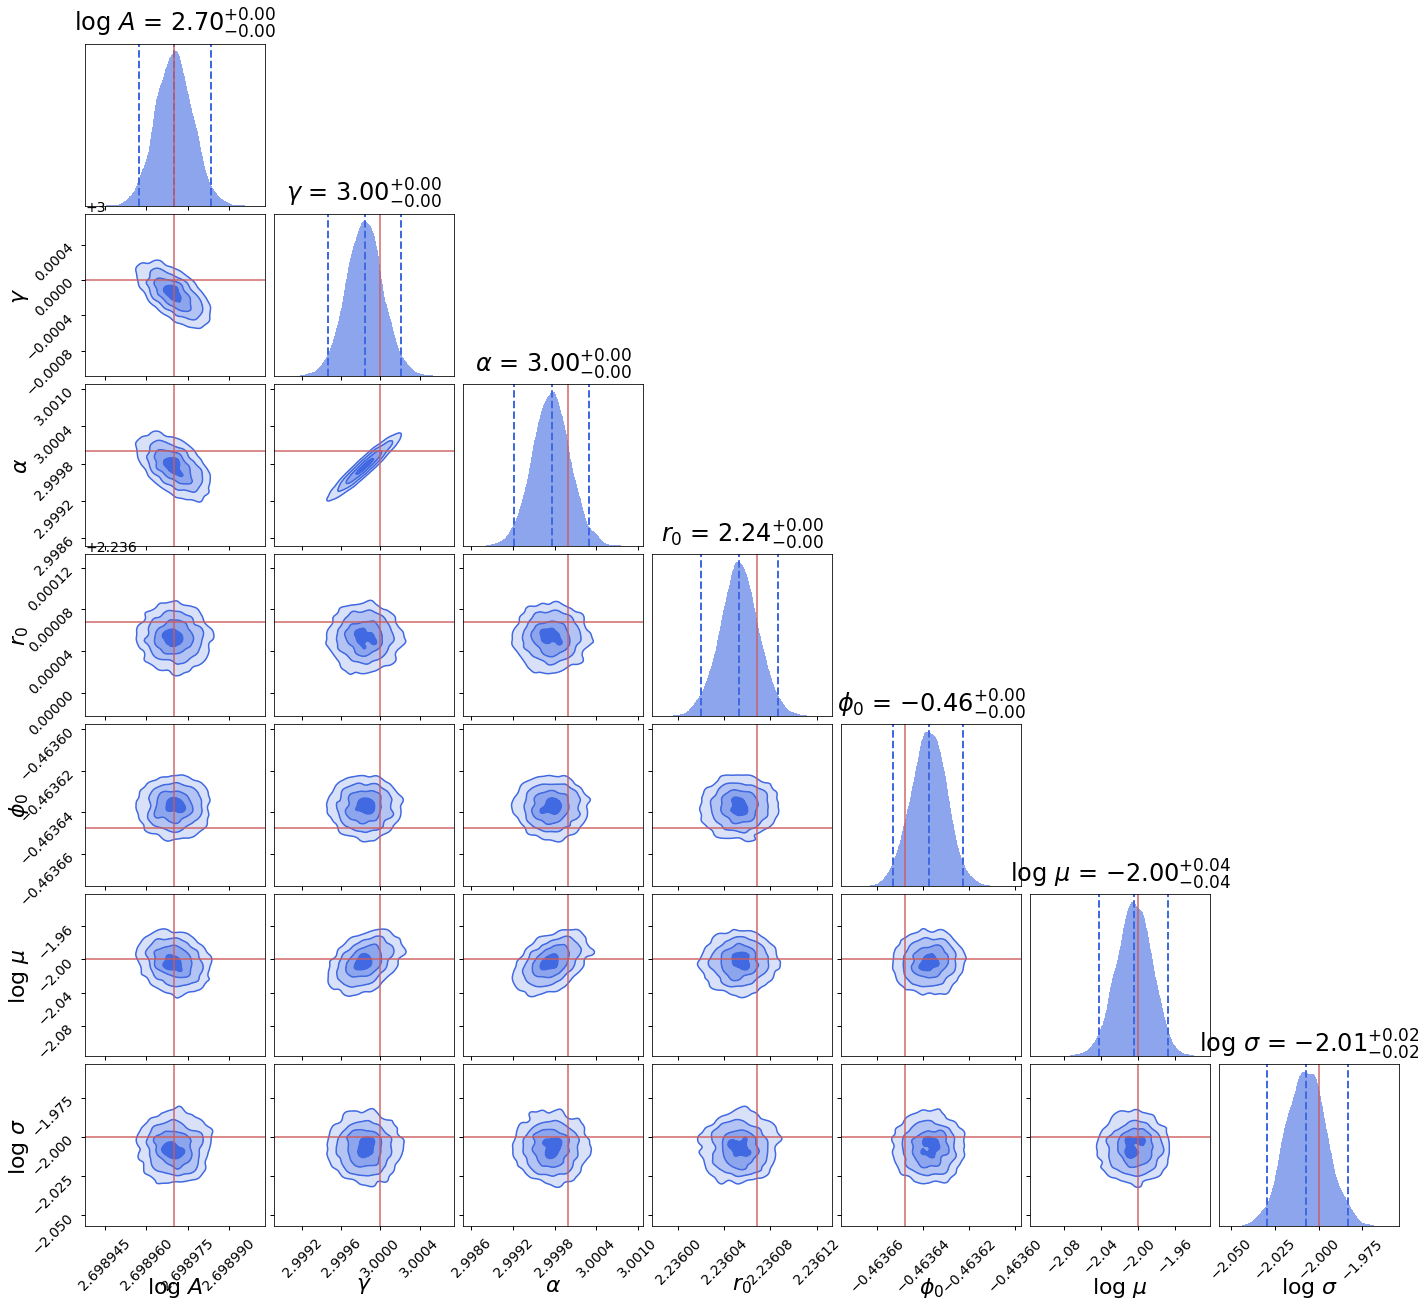

In [236]:
print(truths)
fig, axes = dyplot.cornerplot(pdres, truths=truths, show_titles=True, 
                              color="royalblue", truth_color="indianred",
                              title_kwargs={'fontsize':24, 'y': 1.04}, labels=labels,
                              label_kwargs={'fontsize':22},
                              fig=plt.subplots(7, 7, figsize=(20, 18)))

### Continue sampling

In [270]:
pdsampler.run_nested(nlive_batch=200, maxbatch=10,
                      dlogz_init=dlogz, wt_kwargs={'pfrac': 0.8})
pdres = pdsampler.results

iter: 23172 | batch: 10 | bound: 676 | nc: 179 | ncall: 4407026 | eff(%):  0.526 | loglstar: 2264.975 < 2273.892 < 2272.228 | logz: 2207.957 +/-  0.551 | stop:  1.477                                


(2.6989700043360187, 3, 3, 2.23606797749979, -0.4636476090008061, -2.0, -2.0)


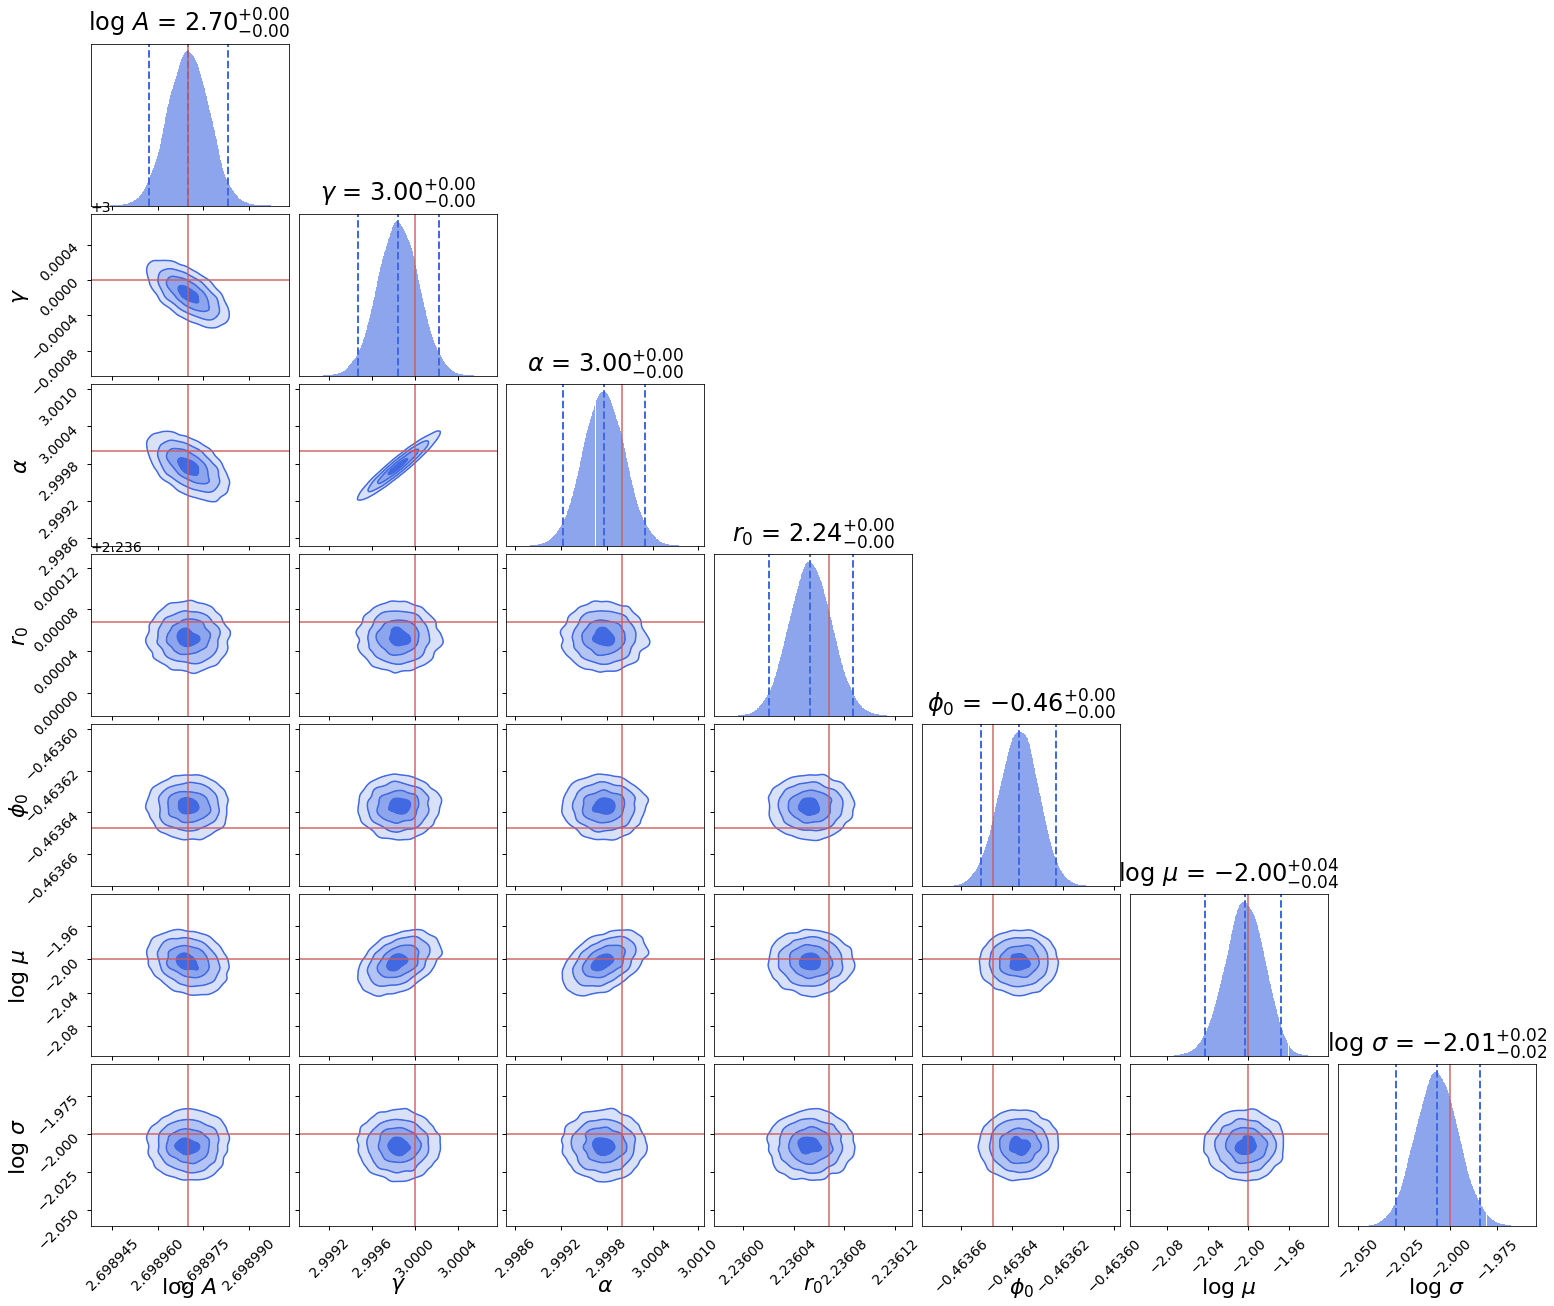

In [274]:
print(truths)
fig, axes = dyplot.cornerplot(pdres, truths=truths, show_titles=True, 
                              color="royalblue", truth_color="indianred",
                              title_kwargs={'fontsize':24, 'y': 1.04}, labels=labels,
                              label_kwargs={'fontsize':22},
                              fig=plt.subplots(7, 7, figsize=(22, 18)))

In [276]:
mypool.close()  # How to continue sample after the pool is closed?